# 客户流失预测模型

客户流失是所有与消费者挂钩行业都会关注的点。因为发展一个新客户是需要一定成本的，一旦客户流失，成本浪费不说，挽回一个客户的成本更大。

## 提出问题

1. 哪些用户可能会流失?
2. 流失概率更高的用户有什么共同特征？

## 理解数据

### 采集数据

1. 本数据集来自DataFountain，数据源地址：https://www.datafountain.cn/dataSets/35/details#
2. 本数据集描述了电信用户是否流失以及其相关信息，共包含7044 条数据，共20 个字段，介绍下各个字段：
- customerID ：用户ID
- gender：性别（Female & Male）
- SeniorCitizen ：老年人（1 表示是，0 表示不是）
- Partner ：是否有配偶（Yes or No）
- Dependents ：是否经济独立（Yes or No）
- tenure ：客户的职位（0-72，共73 个职位）
- PhoneService ：是否开通电话服务业务（Yes or No）
- MultipleLines：是否开通了多线业务（Yes，No or No phoneservice）
- InternetService：是否开通互联网服务（No， DSL，fiber optic）
- OnlineSecurity：是否开通网络安全服务（Yes，No，No internetserive）
- OnlineBackup：是否开通在线备份业务（Yes，No，No internetserive）
- DeviceProtection：是否开通了设备保护业务（Yes，No，No internetserive）
- TechSupport：是否开通了技术支持服务（Yes，No，No internetserive）
- StreamingTV：是否开通网络电视（Yes，No，No internetserive）
- StreamingMovies：是否开通网络电影（Yes，No，No internetserive）
- Contract：签订合同方式（按月，一年，两年）
- PaperlessBilling：是否开通电子账单（Yes or No）
- PaymentMethod：付款方式（bank transfer，credit card，electronic check，mailed check）
- MonthlyCharges：月费用
- TotalCharges：总费用
- Churn：该用户是否流失（Yes or No）

### 导入数据

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.cm as cm

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
telcom = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

### 查看数据集信息

In [3]:
telcom.head(6)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes


In [4]:
# 查看数据集大小
telcom.shape

(7043, 21)

In [5]:
# 获取描述统计信息
telcom.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 数据清洗

### 查找缺失值

In [6]:
pd.isnull(telcom).sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
telcom['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

数据集中有5174 名用户没流失，有1869 名客户流失，数据集不均衡。

### 查看数据类型

In [8]:
# 查看数据类型
telcom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


TotalCharges 表示总费用，这里为对象类型，需要转换为float 类型。

### 转换类型

In [9]:
# TotalCharges类型转换
"""
convert_numeric=True表示强制转换数字（包括字符串），不可转换的值变为NaN
"""
telcom['TotalCharges'] = telcom['TotalCharges'].apply(pd.to_numeric, errors='coerce')
telcom['TotalCharges'].dtypes

dtype('float64')

### 处理缺失值

In [10]:
telcom.dropna(inplace=True)
telcom.shape

(7032, 21)

In [11]:
# 再次查找缺失值
pd.isnull(telcom['TotalCharges']).sum()

0

### 数据归一化处理

In [12]:
# 数据归一化处理
# 对Churn中的值Yes和No分别用1和0替换，方便后续处理
telcom['Churn'] = telcom['Churn'].map({'Yes':1, 'No':0})
telcom['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

## 数据可视化

### 查看客户流失占比

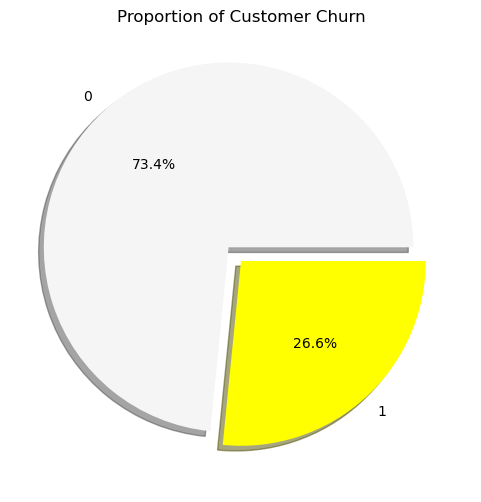

In [13]:
# 查看客户流失占比
"""
画饼图参数：

"""
churnvalue = telcom['Churn'].value_counts()
labels = telcom['Churn'].value_counts().index

rcParams['figure.figsize'] = 6, 6
plt.pie(churnvalue, labels=labels, colors=['whitesmoke', 'yellow'], explode=(0.1, 0), autopct='%1.1f%%', shadow=True)
plt.title('Proportion of Customer Churn')
plt.show()

从图中可以看出，流失客户占整体客户的26.6%。


### 性别、老年人、配偶、亲属对客户流失率的影响

Text(0.5, 1.0, 'Chrun by Dependents')

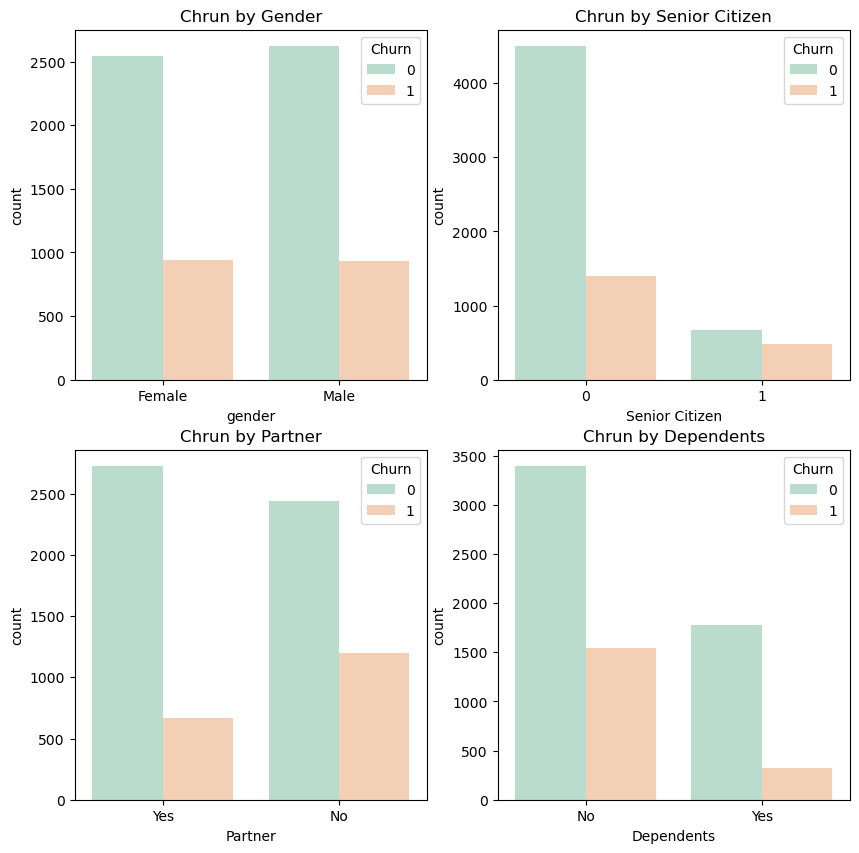

In [14]:
# 性别、老年人、配偶、亲属对客户流失率的影响

f, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))

plt.subplot(2, 2, 1)
gender = sns.countplot(x='gender', hue='Churn', data=telcom, palette='Pastel2')
plt.xlabel('gender')
plt.title('Chrun by Gender')

plt.subplot(2, 2, 2)
seniorcitizen = sns.countplot(x='SeniorCitizen', hue='Churn', data=telcom, palette='Pastel2')
plt.xlabel('Senior Citizen')
plt.title('Chrun by Senior Citizen')

plt.subplot(2, 2, 3)
partner = sns.countplot(x='Partner', hue='Churn', data=telcom, palette='Pastel2')
plt.xlabel('Partner')
plt.title('Chrun by Partner')

plt.subplot(2, 2, 4)
Dependents = sns.countplot(x='Dependents', hue='Churn', data=telcom, palette='Pastel2')
plt.xlabel('Dependents')
plt.title('Chrun by Dependents')

可以看出，男性与女性用户之间的流失情况基本没有差异，而在老年用户中流失占比明显比非老年用户更高，在所有数据中未婚与已婚人数基本持平，但未婚中流失人数比已婚中的流失人数高出了快一倍，从经济独立情况来看，经济未独立的用户流失率要远远高于经济独立的用户。

### 特征提取

In [15]:
# 提取特征
charges = telcom.iloc[:, 1:20]
# 对特征进行编码
"""

"""
corrDf = charges.apply(lambda x: pd.factorize(x)[0])
corrDf.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,1,1
2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,2,2
3,1,0,1,0,3,0,0,0,1,1,1,1,0,0,1,1,2,3,3
4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,4,4


### 构造相关性矩阵

In [16]:
# 构造性关性矩阵
corr = corrDf.corr()
corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
gender,1.000000,-0.001819,0.001379,0.010349,-0.000265,-0.007515,-0.010284,-0.002236,-0.004365,0.011081,0.004526,0.000057,0.000578,-0.001339,0.000095,0.011902,-0.004928,-0.008017,-0.012153
SeniorCitizen,-0.001819,1.000000,-0.016957,-0.210550,0.012240,0.008392,0.113769,-0.032160,-0.210546,-0.144762,-0.156700,-0.223438,-0.129721,-0.120658,-0.141820,-0.156258,-0.093712,0.049154,0.022949
Partner,0.001379,-0.016957,1.000000,-0.452269,-0.100513,-0.018397,-0.118037,-0.000513,-0.081078,0.091536,-0.093391,-0.068277,-0.079066,-0.075310,-0.294094,-0.013957,-0.133280,-0.036518,-0.044214
Dependents,0.010349,-0.210550,-0.452269,1.000000,0.044138,-0.001078,-0.019178,0.044030,0.188889,0.061970,0.154819,0.179176,0.138809,0.125086,0.240556,0.110131,0.124002,-0.028706,0.009710
tenure,-0.000265,0.012240,-0.100513,0.044138,1.000000,-0.017864,0.064580,-0.012924,0.014436,-0.066232,0.034744,0.030489,0.024719,0.030252,0.118664,-0.013160,0.075533,0.042605,0.112813
PhoneService,-0.007515,0.008392,-0.018397,-0.001078,-0.017864,1.000000,0.674824,0.387266,0.125544,0.129432,0.138938,0.123533,0.171773,0.164379,0.003019,-0.016696,-0.003106,-0.141696,-0.030534
MultipleLines,-0.010284,0.113769,-0.118037,-0.019178,0.064580,0.674824,1.000000,0.186852,-0.066695,-0.130978,-0.012819,-0.066814,0.030524,0.027944,0.084037,-0.133538,0.026248,0.024221,0.014915
InternetService,-0.002236,-0.032160,-0.000513,0.044030,-0.012924,0.387266,0.186852,1.000000,0.607412,0.650084,0.662685,0.609422,0.712715,0.708336,0.099579,0.138166,0.008851,-0.288948,-0.037709
OnlineSecurity,-0.004365,-0.210546,-0.081078,0.188889,0.014436,0.125544,-0.066695,0.607412,1.000000,0.621270,0.748684,0.790951,0.701526,0.704672,0.389138,0.333656,0.214330,-0.219289,-0.024821
OnlineBackup,0.011081,-0.144762,0.091536,0.061970,-0.066232,0.129432,-0.130978,0.650084,0.621270,1.000000,0.600952,0.616520,0.603551,0.606037,0.034745,0.260691,0.003786,-0.283212,-0.053770


### 使用热地图显示相关系数矩阵

Text(0.5, 1.0, 'Correlation between variables')

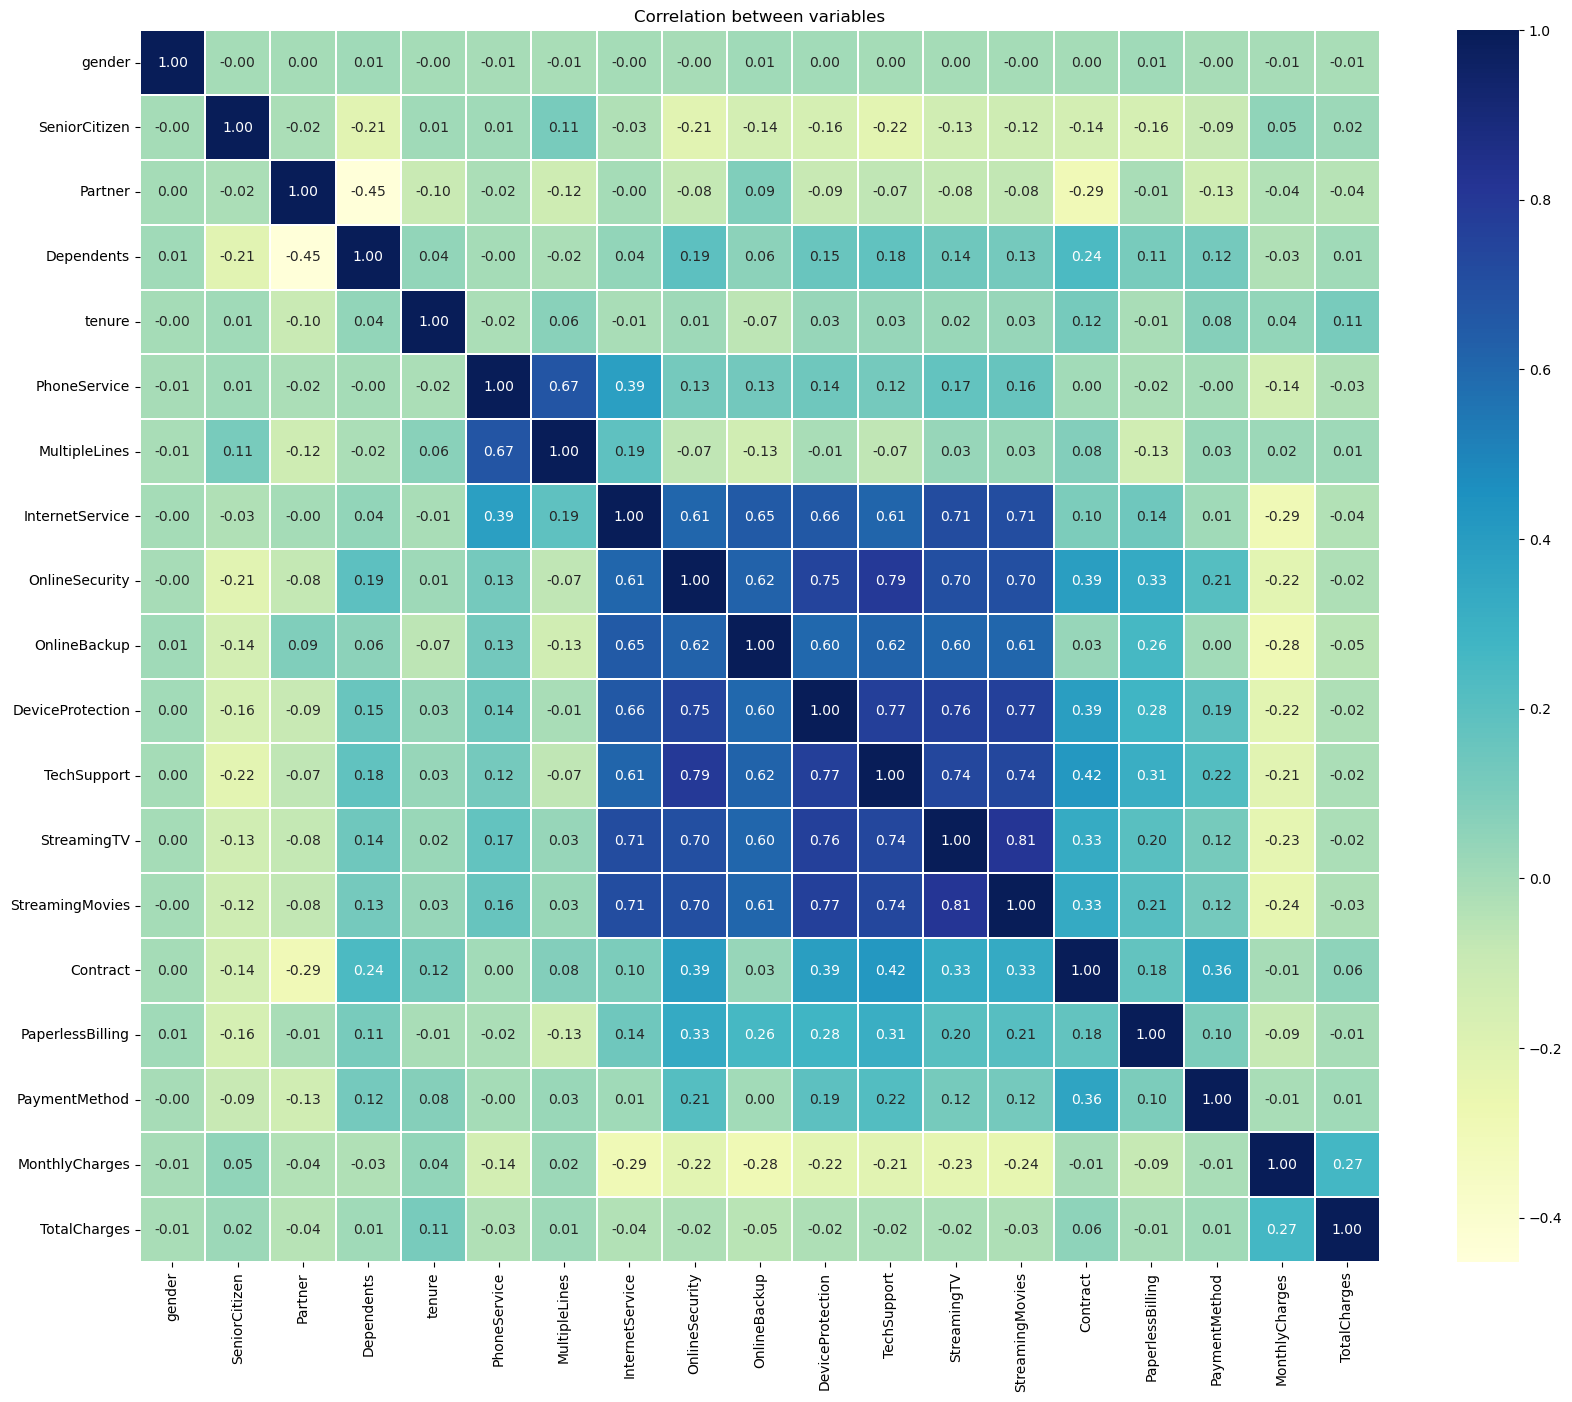

In [17]:
# 使用热地图显示相关系数矩阵

plt.figure(figsize=(20,16))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
                 linewidths=0.2, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Correlation between variables')

从上图可以看出，互联网服务、网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视和网络电影之间存在较强的相关性，多线业务和电话服务之间也有很强的相关性，并且都呈强正相关关系。

### 使用one-hot编码

In [18]:
# 使用one-hot编码
tel_dummies = pd.get_dummies(telcom.iloc[:, 1:22], dtype=int)
tel_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


### 电信用户是否流失与各变量之间的相关性

Text(0.5, 1.0, 'Correlation between Churn and varibales')

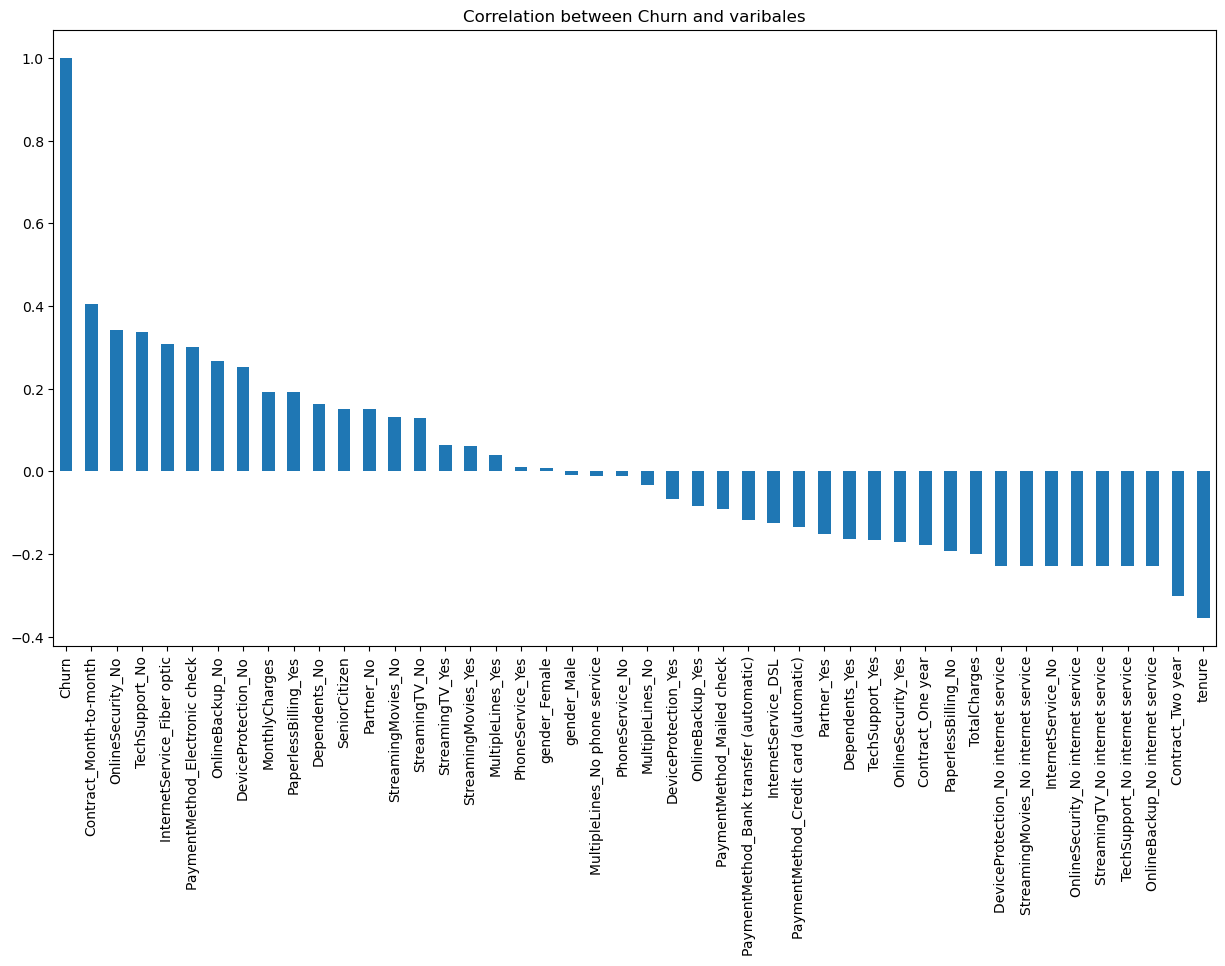

In [19]:
# 电信用户是否流失与各变量之间的相关性
plt.figure(figsize=(15, 8))
tel_dummies.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation between Churn and varibales')

由图上可以看出，变量gender 和PhoneService 处于图形中间，其值接近于0 ，这两个变量对电信客户流失预测影响非常小，可以直接舍弃。

### 网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视、网络电影和无互联网服务对客户流失率的影响

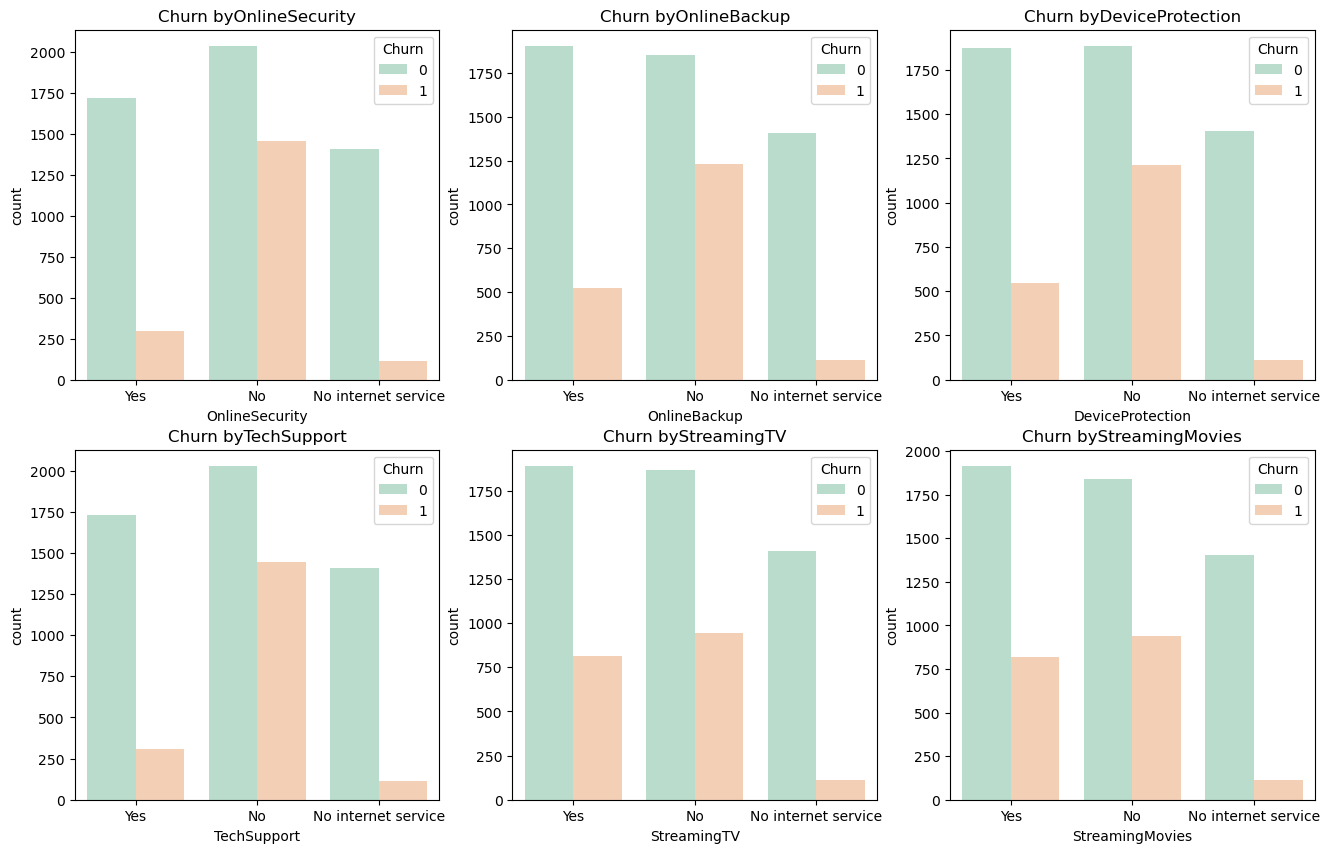

In [20]:
# 网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视、网络电影和无互联网服务对客户流失率的影响
covariates = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
for i, item in enumerate(covariates):
    plt.subplot(2,3,(i+1))
    ax=sns.countplot(x=item, hue='Churn', data=telcom, palette='Pastel2', order=['Yes', 'No', 'No internet service'])
    plt.xlabel(str(item))
    plt.title('Churn by' + str(item))
    i = i + 1
plt.show()

由上图可以看出，在网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视和网络电影六个变量中，没有互联网服务的客户流失率值是相同的，都是相对较低。这可能是因为以上六个因素只有在客户使用互联网服务时才会影响客户的决策，这六个因素不会对不使用互联网服务的客户决定是否流失产生推论效应。

### 签订合同方式对客户流失率的影响

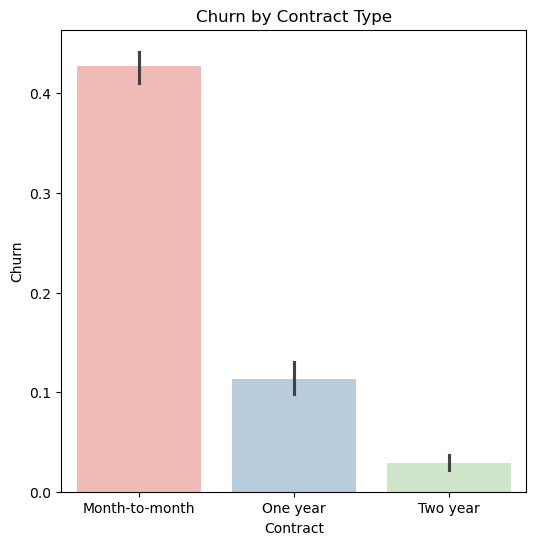

In [21]:
# 签订合同方式对客户流失率的影响
sns.barplot(x='Contract', y='Churn', data=telcom, palette='Pastel1', order=['Month-to-month', 'One year', 'Two year'])
plt.title('Churn by Contract Type')
plt.show()

由图上可以看出，签订合同方式对客户流失率影响为：按月签订> 按一年签订> 按两年签订，这可能表明，设定长期合同对留住现有客户更有效。

### 付款方式对客户流失率的影响

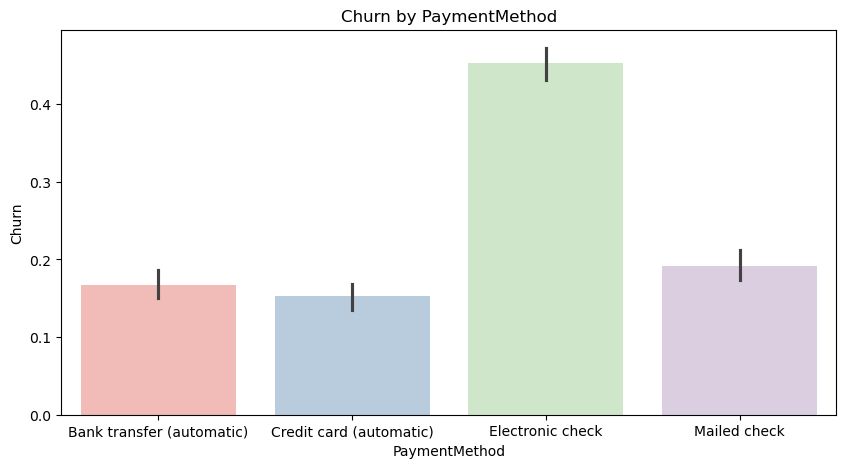

In [22]:
# 付款方式对客户流失率的影响
plt.figure(figsize=(10, 5))
sns.barplot(x='PaymentMethod', y='Churn', data=telcom, palette='Pastel1',
            order=['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check'])
plt.title('Churn by PaymentMethod')
plt.show()

由图上可以看出，在四种支付方式中，使用Electronic check 的用户流流失率最高，其他三种支付方式基本持平，因此可以推断电子账单在设计上影响用户体验。

## 数据预处理

由前面结果可知，CustomerID 表示每个客户的随机字符，对后续建模不影响，这里选择删除CustomerID 列；gender 和PhoneService 与流失率的相关性低，可直接忽略。

In [23]:
telcomvar=telcom.iloc[:,2:20]
telcomvar.drop('PhoneService', axis=1, inplace=True)
telcom_id = telcom['customerID']
telcomvar.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


#### 对客户的职位、月费用和总费用进行去均值和方差缩放，对数据进行标准化

In [24]:
# 对客户的职位、月费用和总费用进行去均值和方差缩放，对数据进行标准化
scaler = StandardScaler(copy=False)
scaler.fit_transform(telcomvar[['tenure', 'MonthlyCharges', 'TotalCharges']])

array([[-1.28024804, -1.16169394, -0.99419409],
       [ 0.06430269, -0.26087792, -0.17373982],
       [-1.23950408, -0.36392329, -0.95964911],
       ...,
       [-0.87280842, -1.17000405, -0.85451414],
       [-1.15801615,  0.31916782, -0.87209546],
       [ 1.36810945,  1.35793167,  2.01234407]])

In [25]:
telcomvar[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(telcomvar[['tenure', 'MonthlyCharges', 'TotalCharges']])

### 使用箱线图查看数据是否存在异常值

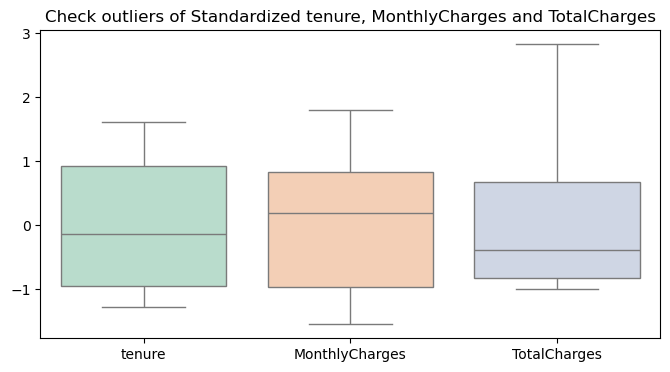

In [26]:
plt.figure(figsize=(8, 4))
numbox = sns.boxplot(data=telcomvar[['tenure', 'MonthlyCharges', 'TotalCharges']], palette='Pastel2')
plt.title('Check outliers of Standardized tenure, MonthlyCharges and TotalCharges')
plt.show()

由以上结果可以看出，在三个变量中不存在明显的异常值。

### 查看对象类型字段中存在的值

In [27]:
# 查看对象类型字段中存在的值
def uni(columnlabel):
    print(columnlabel, '--', telcomvar[columnlabel].unique())

telcomobject = telcomvar.select_dtypes(['object'])
for i in range(0, len(telcomobject.columns)):
    uni(telcomobject.columns[i])

Partner -- ['Yes' 'No']
Dependents -- ['No' 'Yes']
MultipleLines -- ['No phone service' 'No' 'Yes']
InternetService -- ['DSL' 'Fiber optic' 'No']
OnlineSecurity -- ['No' 'Yes' 'No internet service']
OnlineBackup -- ['Yes' 'No' 'No internet service']
DeviceProtection -- ['No' 'Yes' 'No internet service']
TechSupport -- ['No' 'Yes' 'No internet service']
StreamingTV -- ['No' 'Yes' 'No internet service']
StreamingMovies -- ['No' 'Yes' 'No internet service']
Contract -- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -- ['Yes' 'No']
PaymentMethod -- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


综合之前的结果来看，在六个变量中存在No internet service，即无互联网服务对客户流失率影响很小，这些客户不使用任何互联网产品，因此可以将No internet service和No 是一样的效果，可以使用No替代No internet service。

In [28]:
# 替换值
telcomvar.replace(to_replace='No internet service', value='No', inplace=True)
telcomvar.replace(to_replace='No phone service', value='No', inplace=True)
for i in range(0, len(telcomobject.columns)):
    uni(telcomobject.columns[i])

Partner -- ['Yes' 'No']
Dependents -- ['No' 'Yes']
MultipleLines -- ['No' 'Yes']
InternetService -- ['DSL' 'Fiber optic' 'No']
OnlineSecurity -- ['No' 'Yes']
OnlineBackup -- ['Yes' 'No']
DeviceProtection -- ['No' 'Yes']
TechSupport -- ['No' 'Yes']
StreamingTV -- ['No' 'Yes']
StreamingMovies -- ['No' 'Yes']
Contract -- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -- ['Yes' 'No']
PaymentMethod -- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


### 使用Scikit-learn标签编码,将分类数据转换为整数编码

In [29]:
# 使用Scikit-learn标签编码,将分类数据转换为整数编码
def labelencode(columnlabel):
    telcomvar[columnlabel] = LabelEncoder().fit_transform(telcomvar[columnlabel])

for i in range(0, len(telcomobject.columns)):
    labelencode(telcomobject.columns[i])

for i in range(0, len(telcomobject.columns)):
    uni(telcomobject.columns[i])


Partner -- [1 0]
Dependents -- [0 1]
MultipleLines -- [0 1]
InternetService -- [0 1 2]
OnlineSecurity -- [0 1]
OnlineBackup -- [1 0]
DeviceProtection -- [0 1]
TechSupport -- [0 1]
StreamingTV -- [0 1]
StreamingMovies -- [0 1]
Contract -- [0 1 2]
PaperlessBilling -- [1 0]
PaymentMethod -- [2 3 0 1]


## 构建模型

### 建立训练数据集和测试数据集

In [30]:
"""


"""

X = telcomvar
y = telcom['Churn'].values

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print(sss)
print('训练集和测试集被分成的组数:', sss.get_n_splits(X, y))

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)
训练集和测试集被分成的组数: 5


In [31]:
# 建立训练数据和测试数据
for train_index, test_index in sss.split(X, y):
    print('train:', train_index, 'test:', test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

train: [3780 1588 2927 ... 3956 6130 6814] test: [5126 2423 2498 ... 6703 6618 6010]
train: [6916 6953 5388 ... 6156 3262 3471] test: [4097 4734 2309 ... 1278 1724 5508]
train: [1218 2877 3756 ...  848 4568 6967] test: [ 133 1822 5303 ... 3150 5611 4569]
train: [2552 4723 2055 ... 4030 2165 1994] test: [ 233  438 4434 ... 4625 1121 3422]
train: [4040 1561 6463 ... 2550 6727 4009] test: [4581 3898 3153 ... 2095 1765 2249]


In [32]:
# 输出数据集大小
print('原始数据特征：', X.shape,
      '训练数据特征：', X_train.shape,
      '测试数据特征：', X_test.shape)
print('原始数据特征：', y.shape,
      '   训练数据特征：', y_train.shape,
      '   测试数据特征：', y_test.shape)

原始数据特征： (7032, 17) 训练数据特征： (5625, 17) 测试数据特征： (1407, 17)
原始数据特征： (7032,)    训练数据特征： (5625,)    测试数据特征： (1407,)


### 选择机器学习算法

In [33]:
# 选择分类算法，这里选用8种分类算法
Classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'XGB': XGBClassifier(),''
    'CatBoost': CatBoostClassifier(logging_level='Silent')
    }

### 训练模型

In [34]:
Classify_result=[]
names=[]
prediction=[]
for name, model in Classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    class_eva = pd.DataFrame([recall,precision,f1])
    Classify_result.append(class_eva)
    name = pd.Series(name)
    names.append(name)
    y_pred = pd.Series(y_pred)
    prediction.append(y_pred)

### 模型评估

召回率（recall）的含义是：原本为对的当中，预测为对的比例（值越大越好，1 为理想状态）
精确率、精度（precision）的含义是：预测为对的当中，原本为对的比例（值越大越好，1 为理想状态）
F1 分数（F1-Score）指标综合了Precision 与Recall 的产出的结果
F1-Score 的取值范围从0 到1 的，1 代表模型的输出最好，0 代表模型的输出结果最差。

In [35]:
# 模型评估
names=pd.DataFrame(names)
names=names[0].tolist()
result=pd.concat(Classify_result,axis=1)
result.columns=names
result.index=['recall', 'precision', 'f1_score']
result

,Random Forest,Support Vector Machine,Naive Bayes,Decision Tree,AdaBoostClassifier,GradientBoostingClassifier,XGB,CatBoost
recall,0.478610,0.483957,0.740642,0.494652,0.548128,0.545455,0.537433,0.532086
precision,0.625874,0.688213,0.552894,0.504087,0.672131,0.673267,0.628125,0.658940
f1_score,0.542424,0.568289,0.633143,0.499325,0.603829,0.602659,0.579251,0.588757


综上所述，在8种分类算法中朴素贝叶斯（Naive Bayes）的F1 分数最大为63.31%，所以使用朴素贝叶斯模型效果最好。

## 实施方案

In [36]:
# 预测数据集特征（由于没有提供预测数据集，这里随便选取10行作为需要预测的数据集）
pred_X = X.iloc[20:31,]
# 提取customerID
pred_id = telcom_id.iloc[20:31,]

# 使用朴素贝叶斯方法，对预测数据集中的生存情况进行预测
model = GaussianNB()
model.fit(X_train, y_train)
pred_y = model.predict(pred_X)

# 预测结果
predDF = pd.DataFrame({'customerID':pred_id, 'Churn':pred_y})
predDF

,customerID,Churn
20,8779-QRDMV,1
21,1680-VDCWW,0
22,1066-JKSGK,0
23,3638-WEABW,0
24,6322-HRPFA,0
25,6865-JZNKO,0
26,6467-CHFZW,0
27,8665-UTDHZ,0
28,5248-YGIJN,0
29,8773-HHUOZ,1


## 结论

通过上述分析，我们可以大致勾勒出容易流失的用户特征：
老年用户与未婚且经济未独立的青少年用户更容易流失。
电话服务对用户的流失没有直接的影响。
提供的各项网络服务项目能够降低用户的流失率。
签订合同越久，用户的留存率越高。
采用electronic check 支付的用户更易流失。
针对上述诊断结果，可有针对性的对此提出建议：推荐老年用户与青少年用户采用数字网络，且签订2年期合同（可以各种辅助优惠等营销手段来提高2 年期合同的签订率），若能开通相关网络服务可增加用户粘性，因此可增加这块业务的推广，同时考虑改善电子账单支付的用户体验。